In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def simulate_gbm(initial_price, drift, volatility, num_steps, delta_t):
    '''
    initial_price = float, drift = float, volatility = float, num_steps = int, delta_t = int
    drift is the draft rate (mu), volatility is the standard dev value in the timeframe (sigma)
    num_steps is the required time steps for simulation (t = T). delta_t is the time increment (dt)
    '''
    # initializing a array for storying stock price path with size == steps, initialize all value to zero
    prices = np.zeros(num_steps)
    prices[0] = initial_price

    # GBM formula
    for i in range(1, num_steps):
        epsilon = np.random.normal(0, 1)  # Generate a random number from a standard normal distribution
        drift_component = drift * delta_t  # Drift component of the price change (mu * dt)
        volatility_component = volatility * epsilon * np.sqrt(delta_t)  
        # Volatility component of the price change (sigma * DW, where DW = random variable of standard deviation)
        rateof_price_change = drift_component + volatility_component  # Total price change (dS/S)
        prices[i] = prices[i-1] * np.exp(rateof_price_change)  # Update the price by adding the price change

    return prices

In [3]:
# Plotting Multi Path
def multiPathSim(path):
    '''
    Path: int, specify a number of path for simulation
    '''
    # Simulate GBM paths
    paths = np.zeros((path, num_steps))
    for i in range(num_paths):
        paths[i] = simulate_gbm(initial_price, drift, volatility, num_steps, delta_t)

In [4]:
snp = pd.read_csv("data/SPXall.csv")

In [5]:
snp = snp[['Date', 'Close']]
snp

,Date,Close
0,1927-12-30,17.660000
1,1928-01-03,17.760000
2,1928-01-04,17.719999
3,1928-01-05,17.549999
4,1928-01-06,17.660000
...,...,...
24220,2024-06-03,5283.399902
24221,2024-06-04,5291.339844
24222,2024-06-05,5354.029785
24223,2024-06-06,5352.959961


In [6]:
def dataInRequiredTimeFrame(data, start = "1999-06-01" , end = "2024-06-01", datecol = "Date"):
    '''data: pd.DataFrame, storing the required data to be sliced for timeframe
    start: string, start date required
    end: string, end date required 
    datecol: string, what is the column name that store the Date in the data
    return: sliced pd.DataFrame, the sliced data is returned, inclusive of start and end date data
    '''
    # convert string to datetime object
    start_date, end_date = pd.to_datetime(start), pd.to_datetime(end)
    data[datecol] = pd.to_datetime(data[datecol])
    # filter dataFrame within timeframe
    timefilter = (data[datecol] >= start_date) & (data[datecol] <= end_date)
    data = data[timefilter].reset_index(drop = True)
    # return the sliced dataFrame
    return data

In [7]:
snp = dataInRequiredTimeFrame(data = snp, start = "1999-06-01" , end = "2024-06-01")

In [8]:
snp

,Date,Close
0,1999-06-01,1294.260010
1,1999-06-02,1294.810059
2,1999-06-03,1299.540039
3,1999-06-04,1327.750000
4,1999-06-07,1334.520020
...,...,...
6287,2024-05-24,5304.720215
6288,2024-05-28,5306.040039
6289,2024-05-29,5266.950195
6290,2024-05-30,5235.479980


In [9]:
# In the Journal of Forecasting paper (page 8), the mean daily return (mu) of SPX is neglected
# Therefore we set mu as 0 in the following
mu = 0



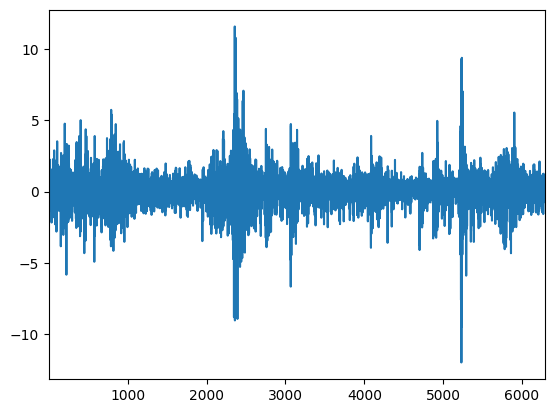

In [10]:
returns = 100 * snp["Close"].pct_change().dropna()
ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())

In [11]:
# TODO: GARCH model
from arch import arch_model

# GARCH Model Fitted with Zero Mean 
# (paper p.7: daily mean return is neglected since its value is too small (empircally 0.06% here)
p, q = 1, 1
am = arch_model(returns, mean = 'Zero', vol='Garch', p=p, q=q)

res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     27,   Neg. LLF: 8923.12523777466
Iteration:     10,   Func. Count:     48,   Neg. LLF: 8718.796829637824
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8718.796829637824
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8718.80
Distribution:                  Normal   AIC:                           17443.6
Method:            Maximum Likelihood   BIC:                           17463.8
                                        No. Observations:                 6291
Date:                Tue, Jun 11 2024   Df Residuals:                     6291
Time:           

Text(0.5, 0, 'Year')

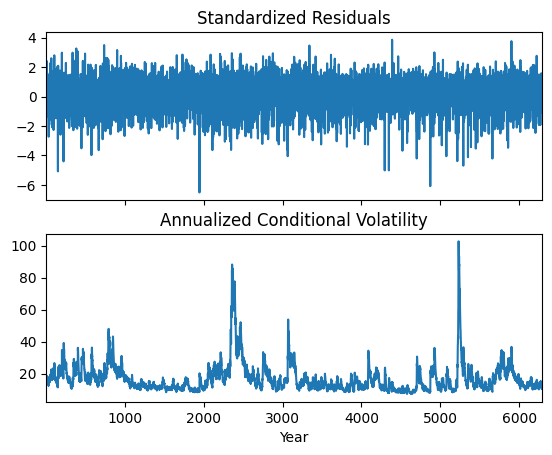

In [12]:
fig = res.plot(annualize="D")
plt.xlabel("Year")


In [31]:
omega, alpha, beta = res.params # get the parameters of GARCH
# Notes: due to returns scaling (*100), omega value has to be rescaled (by 10^-4)
omega /= 10**4

In [32]:
omega

2.122303770936074e-06

In [33]:
long_run_var_d = omega/(1-alpha-beta) # long run variance daily
long_run_var_y = 250 * long_run_var_d # long run variance yearly
long_run_sd_y = np.sqrt(long_run_var_y) # sd yearly (in decimal form) 
print("The long run variance yearly implied by GARCH model is", long_run_sd_y * 100, "%")

The long run variance yearly implied by GARCH model is 18.44042564882312 %


In [16]:
# Parameters

# TODO: Change to S&P parameters (initial_price = S&P value at start date, mu -> data; sigma -> GARCH, steps: change to len between start and end)
initial_price = 100.0
drift = 0.08  # Drift (average return)
volatility = 0.2  # Volatility (standard deviation of returns)
num_steps = 252  # Number of time steps (e.g., trading days in a year)
delta_t = 1/252  # Length of time interval (e.g., 1 trading day)
num_paths = 3  # Number of paths to simulate

# Simulate GBM paths
paths = np.zeros((num_paths, num_steps))
for i in range(num_paths):
    paths[i] = simulate_gbm(initial_price, drift, volatility, num_steps, delta_t)



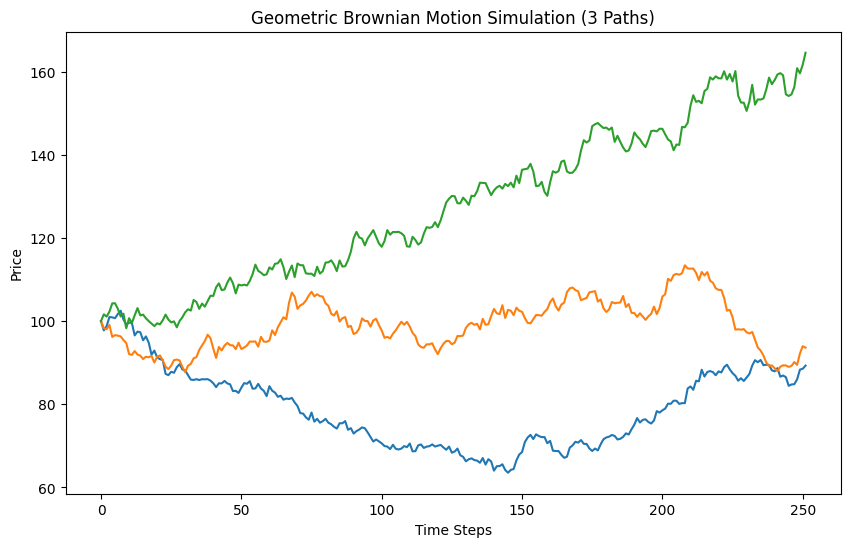

In [17]:
# Plot the simulated price paths
plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(paths[i])
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.title('Geometric Brownian Motion Simulation ({} Paths)'.format(num_paths))
plt.show()